# Two Scan Investigation
Some participants in the ADHD 200 Dataset had 2 scans, this  notebook investigates if the flattened graph features would be represented in a similar part of pca space between scans. This was found not to be the case indicating high individual variability between graph representations

### Imports and Data Loading

In [1]:
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



c:\Users\nici9\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def get_networks(dataset):
    file_list = pd.read_csv(f'../data.nosync/networks_multi/networks_multi/{dataset}_set_files.csv')['file'].to_list()
    networks = []
    for g in file_list:
        g = g.replace('networks_multi', f'networks_multi_correct/networks_multi')
        g = g.replace('data.nosync', f'../data.nosync')

        networks.append([g, nx.read_gml(g)])
    return networks

In [3]:
test_networks = get_networks("test")
val_networks = get_networks("val")
train_networks = get_networks("train")

In [4]:
df_test = pd.DataFrame(test_networks, columns=["filepath","graph"])
df_val = pd.DataFrame(val_networks, columns=["filepath","graph"])
df_train = pd.DataFrame(train_networks, columns=["filepath","graph"])
df_train["split"] = "train"
df_val["split"]   = "val"
df_test["split"]  = "test"
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)


In [5]:
df_all["participant_id"] = df_all["filepath"].str.extract(r"(\d+)_run-")
df_all["dataset"] = df_all["filepath"].str.extract(r"_run-\d+_([^_]+)_")
df_all["diagnosis"] = df_all["filepath"].str.extract(r"_run-\d+_[^_]+_([^_]+)_")
df_all["two_scans"] = df_all.duplicated(subset=["participant_id", "dataset"], keep=False)
df_all_no_graph = df_all.drop("graph", axis = 1)
df_all_no_graph.to_csv("../data/two_scans.csv")
df_all_true = df_all[df_all["two_scans"]==True]
df_all_true.to_csv("../data/two_scans_true.csv")

# only look into participants with 2 scans
df_all = df_all[df_all["two_scans"] ==True].reset_index()

### How do the Networks Differ?

#### PCA

In [6]:
rng = np.random.RandomState(0)


In [7]:
#pca approach 
df_first_scans = df_all["filepath"].str.contains("run-1")

graphs = df_all["graph"].tolist()  # list of all MultiGraph objects
feature_vectors = []
meta_info = []  # store participant IDs & other info
for idx,g in enumerate(graphs):
    # NODE FEATURES
    nodes = pd.DataFrame.from_dict(dict(g.nodes(data=True)), orient='index')
    nodes = nodes.sort_index()  # ensure consistent ordering
    vec_nodes = nodes.to_numpy().flatten()
    # EDGE FEATURES
    edges = pd.DataFrame([data for u,v,key,data in g.edges(keys=True, data=True)])
    edges = edges.sort_index(axis=0)  # sort edges consistently
    edges = edges.drop("feature_name",axis =1)
    vec_edges = edges.to_numpy().flatten()

    # Combine node + edge features
    vec = np.concatenate([vec_nodes, vec_edges])
    if sum(np.isnan(vec_edges)):
        print (sum(np.isnan(vec_edges)))
        print(pd.DataFrame([data for u,v,key,data in g.edges(keys=True, data=True)]))
    feature_vectors.append(vec)
    meta_info.append(df_all.loc[idx, ["participant_id", "dataset"]])

# Stack into 2D array: rows=graphs, columns=features
X = np.stack(feature_vectors)


In [8]:
#scale the data
scaler = StandardScaler()
scaler.fit(X[df_first_scans])
X = scaler.transform(X)

In [9]:
pca = PCA(n_components=20,random_state=rng) 
X_pca = pca.fit_transform(X[df_first_scans])
X_pca_2 = pca.transform(X[np.logical_not(df_first_scans)])
print("Shape of PCA matrix:", X_pca.shape)  
print("Shape of PCA matrix 2nd scans:", X_pca_2.shape)  


Shape of PCA matrix: (145, 20)
Shape of PCA matrix 2nd scans: (145, 20)


<BarContainer object of 20 artists>

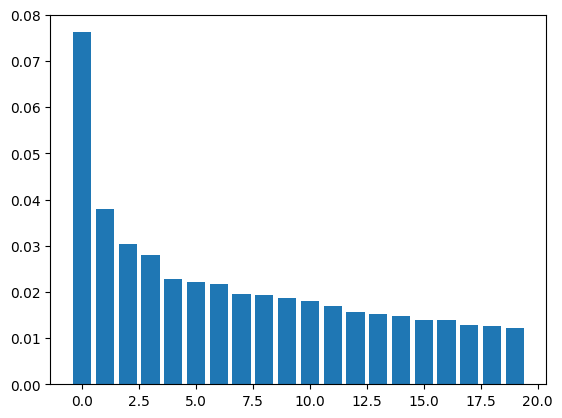

In [10]:
plt.bar([i for i in range(len(pca.explained_variance_ratio_))],pca.explained_variance_ratio_)

In [11]:

pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X[df_first_scans])
X_pca_2 = pca.transform(X[np.logical_not(df_first_scans)])
print("Shape of PCA matrix:", X_pca.shape)  # (num_graphs, 20)
print("Shape of PCA matrix 2nd scans:", X_pca_2.shape)  # (num_graphs, 20)


Shape of PCA matrix: (145, 2)
Shape of PCA matrix 2nd scans: (145, 2)


In [12]:
meta_cols = ["participant_id","dataset","two_scans","diagnosis"]  # add more if needed, e.g., ["participant_id", "session", "group"]

# Create a DataFrame for PCA results
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])


# Combine PCA results with participant info
df_pca = pd.concat([df_all[df_first_scans][meta_cols].reset_index(drop=True), df_pca], axis=1)

print(df_pca.head())
print("Shape of combined DataFrame:", df_pca.shape)


  participant_id  dataset  two_scans diagnosis        PC1        PC2
0        1320247  ADHD200       True        TD -18.876630   2.201669
1        0010059  ADHD200       True        TD   7.167345  -9.741738
2        2730704  ADHD200       True        TD  14.201820  24.880994
3        0010025  ADHD200       True      ADHD  -7.738433  -4.006746
4        1934623  ADHD200       True        TD  -8.522968  -3.482081
Shape of combined DataFrame: (145, 6)


In [13]:
meta_cols = ["participant_id","dataset","two_scans","diagnosis"]  # add more if needed, e.g., ["participant_id", "session", "group"]

# Create a DataFrame for PCA results
df_pca_2 = pd.DataFrame(X_pca_2, columns=[f"PC{i+1}" for i in range(X_pca_2.shape[1])])


# Combine PCA results with participant info
df_pca_2 = pd.concat([df_all[np.logical_not(df_first_scans)][meta_cols].reset_index(drop=True), df_pca_2], axis=1)

print(df_pca_2.head())
print("Shape of combined DataFrame:", df_pca_2.shape)


  participant_id  dataset  two_scans diagnosis       PC1       PC2
0        8415034  ADHD200       True        TD -6.627969  1.616510
1        3011311  ADHD200       True        TD  4.780488  4.517443
2        0010087  ADHD200       True      ADHD  0.231210 -7.037132
3        0010030  ADHD200       True      ADHD -4.433461 -7.704848
4        0010009  ADHD200       True        TD  5.319818 -5.400738
Shape of combined DataFrame: (145, 6)


In [14]:
df_pca_both = pd.concat([df_pca,df_pca_2],axis=0)

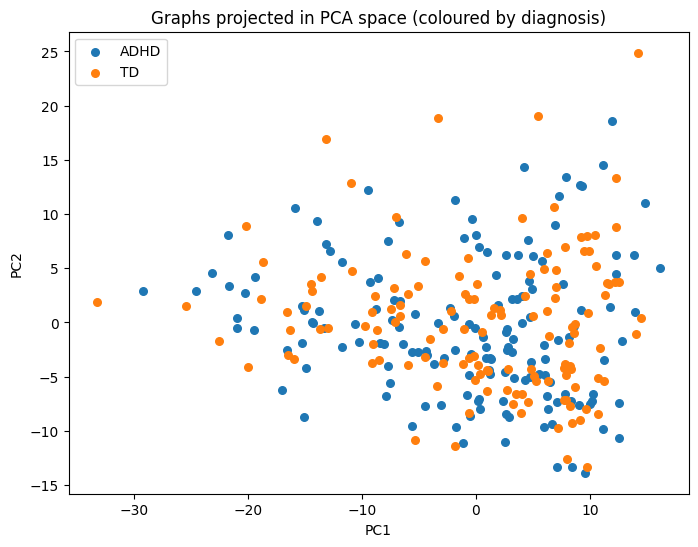

In [15]:

plt.figure(figsize=(8,6))
for pid, group in df_pca_both.groupby("diagnosis"):
    plt.scatter(group["PC1"], group["PC2"], label=pid, s=30)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Graphs projected in PCA space (coloured by diagnosis)")
plt.legend()
plt.show()


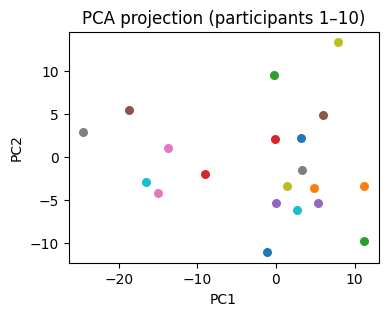

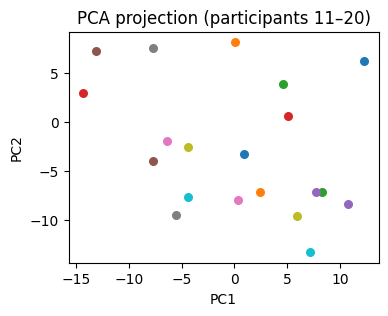

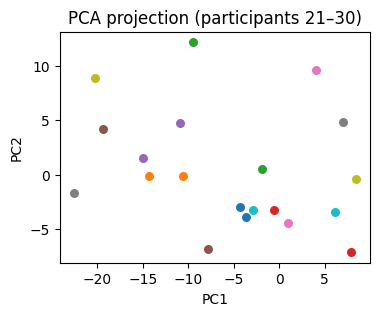

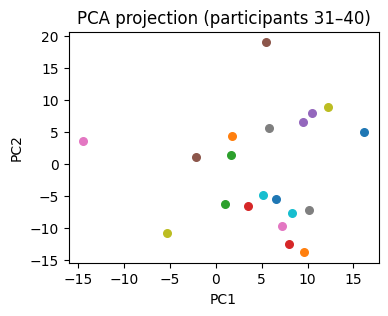

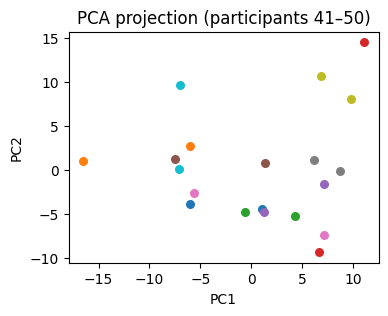

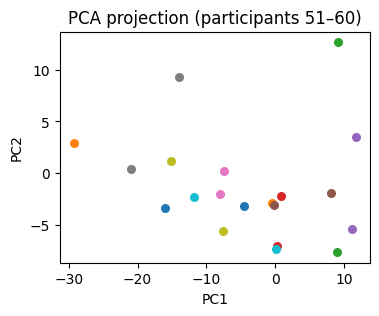

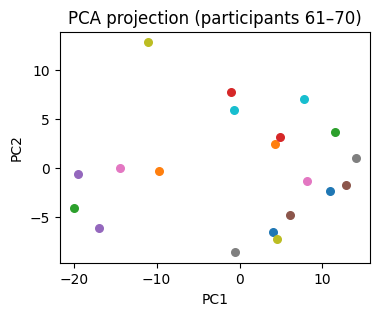

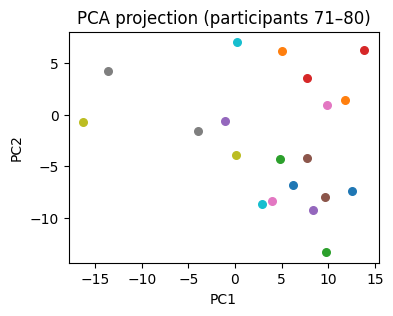

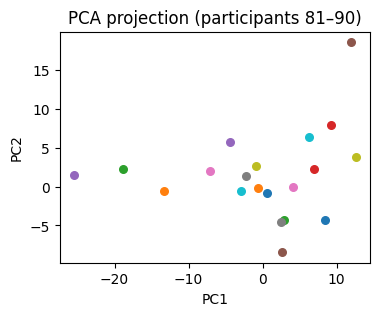

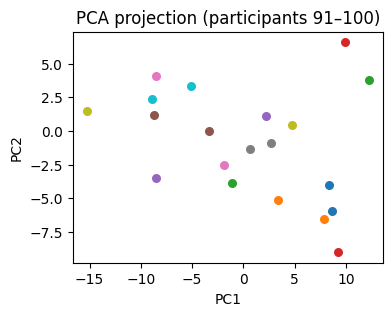

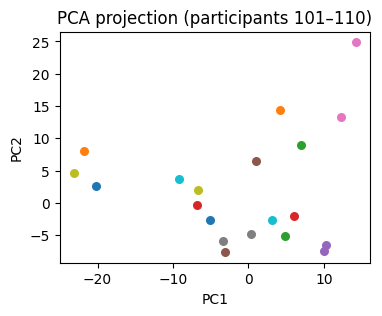

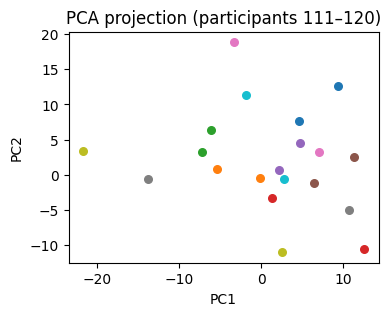

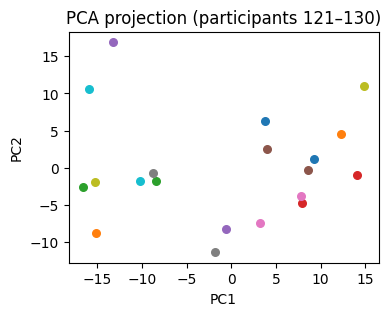

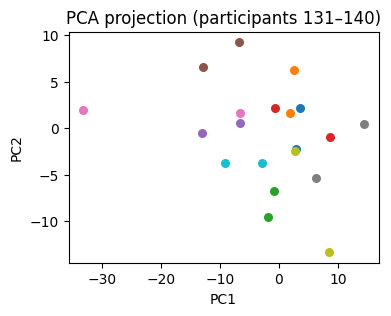

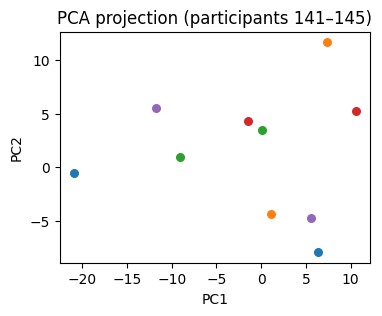

In [16]:

# Filter the dataframe to include only those with two_scans = True
df_filtered = df_pca_both[df_pca_both["two_scans"] == True].copy()

batch_size = 10
fig = None

# Group by participant and plot 10 per figure
for i, (pid, group) in enumerate(df_filtered.groupby("participant_id")):
    # Start new figure every 10 participants
    if i % batch_size == 0:
        if fig is not None:
            plt.xlabel("PC1")
            plt.ylabel("PC2")
            plt.title(f"PCA projection (participants {i - batch_size + 1}–{i})")
            plt.show()
        fig = plt.figure(figsize=(4, 3))

    plt.scatter(group["PC1"], group["PC2"], label=pid, s=30)

# Show last batch if it didn’t close exactly on a multiple of 10
if fig is not None:
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"PCA projection (participants {i - (i % batch_size) + 1}–{i+1})")
    plt.show()


### umap

c:\Users\nici9\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape of UMAP embedding: (290, 2)


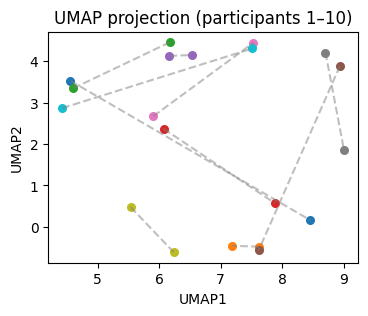

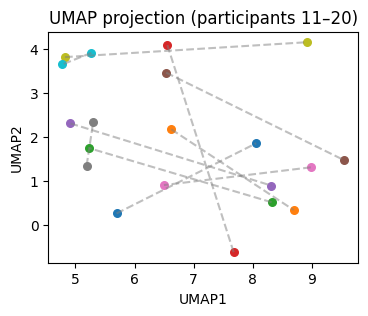

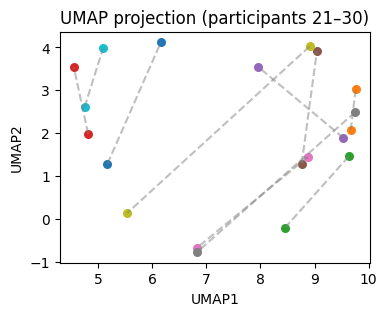

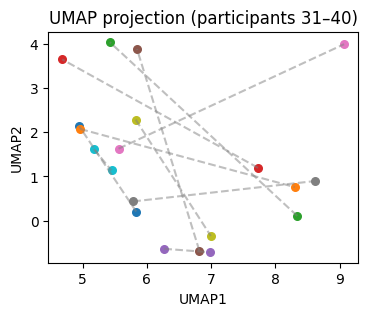

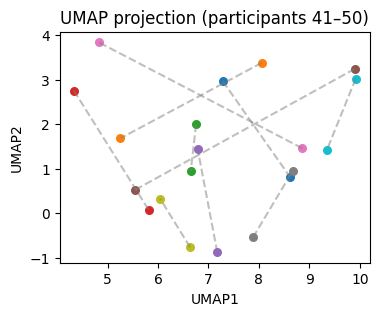

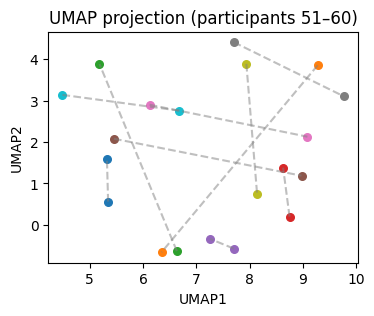

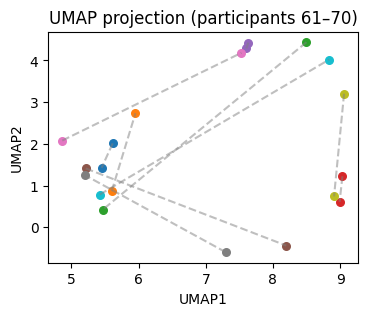

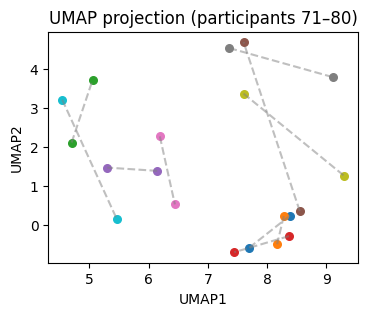

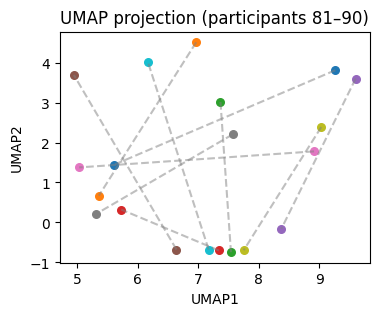

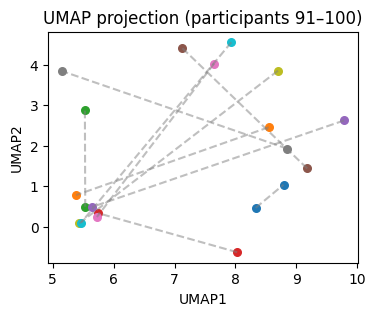

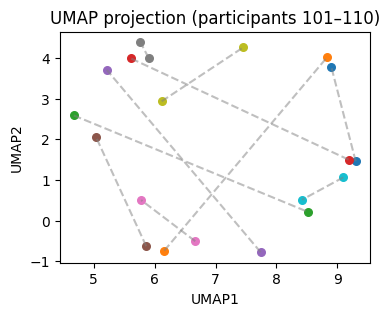

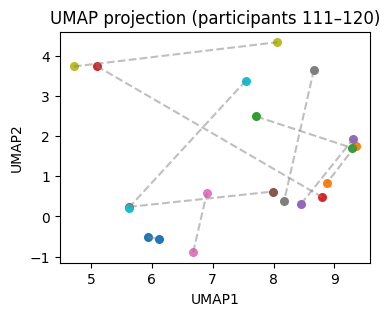

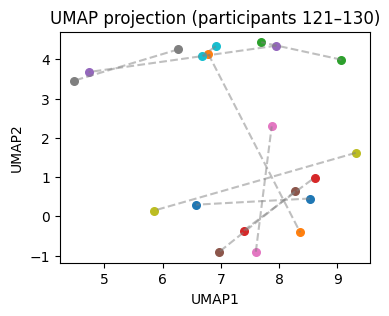

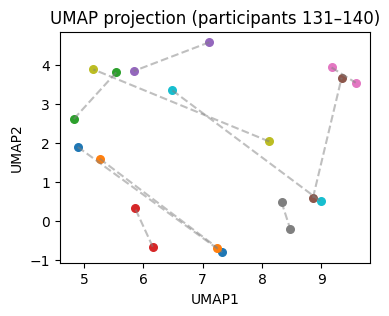

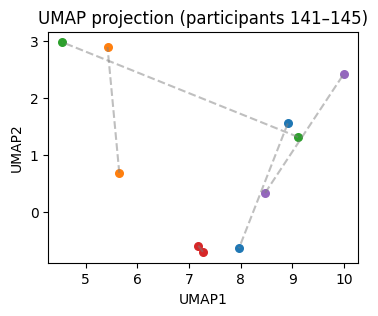

In [17]:

# --- Step 1: Compute UMAP ---
reducer = umap.UMAP(n_components=2, random_state=rng,n_neighbors=5,min_dist=0.01)
reducer.fit(X[df_first_scans])
X_umap = reducer.transform(X)

print("Shape of UMAP embedding:", X_umap.shape)  # (num_graphs, 2)

# --- Step 2: Combine with metadata ---
df_umap = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df_umap = pd.concat([df_all.reset_index(drop=True), df_umap], axis=1)


# --- Step 3: Plot 10 participants at a time ---
batch_size = 10
fig = None

for i, (pid, group) in enumerate(df_umap.groupby("participant_id")):
    # Start new figure every 10 participants
    if i % batch_size == 0:
        if fig is not None:
            plt.xlabel("UMAP1")
            plt.ylabel("UMAP2")
            plt.title(f"UMAP projection (participants {i - batch_size + 1}–{i})")
            plt.show()
        fig = plt.figure(figsize=(4, 3))

    plt.scatter(group["UMAP1"], group["UMAP2"], label=pid, s=30)
    if len(group) == 2:
        plt.plot(group["UMAP1"], group["UMAP2"], linestyle='--', color='gray', alpha=0.5)

# Final figure (if total not multiple of 10)
if fig is not None:
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(f"UMAP projection (participants {i - (i % batch_size) + 1}–{i+1})")
    plt.show()


#### Plot by data set

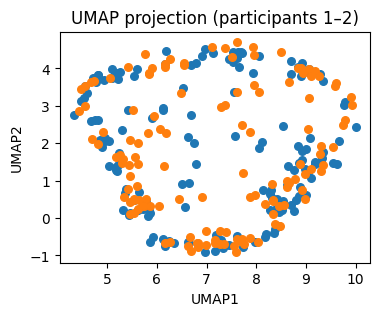

In [18]:


batch_size = 1000
fig = None

for i, (pid, group) in enumerate(df_umap.groupby("diagnosis")):
    # Start new figure every 10 participants
    if i % batch_size == 0:
        if fig is not None:
            plt.xlabel("UMAP1")
            plt.ylabel("UMAP2")
            plt.title(f"UMAP projection (participants {i - batch_size + 1}–{i})")
            plt.show()
        fig = plt.figure(figsize=(4, 3))

    plt.scatter(group["UMAP1"], group["UMAP2"], label=pid, s=30)
    if len(group) == 2:
        plt.plot(group["UMAP1"], group["UMAP2"], linestyle='--', color='gray', alpha=0.5)

# Final figure (if total not multiple of 10)
if fig is not None:
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(f"UMAP projection (participants {i - (i % batch_size) + 1}–{i+1})")
    plt.show()
